# Final Project | Cody Laurie

In [2]:
import pandas as pd

# Load CAASPP dataset caret-delimited "^" with latin1 encoding
caaspp = pd.read_csv(
    "sb_ca2024_all_csv_v1.txt",
    delimiter="^",
    encoding="latin1",   # fixes UnicodeDecodeError
    dtype={
        "County Code": str,
        "District Code": str,
        "School Code": str
    }
)

# Create CDSCode (County + District + School) → 14-digit string
caaspp["CDSCode"] = (
    caaspp["County Code"].str.zfill(2) +
    caaspp["District Code"].str.zfill(5) +
    caaspp["School Code"].str.zfill(7)
)

# Load DF dataset (budget/expenditure, your pasted table)
df = pd.read_csv(
    "df_3_4_inner.csv",
    dtype=str   # keep codes as strings (CDSCODE, etc.)
)

# Drop unnamed index column if it exists
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]

# Make sure CDSCODE is a 14-digit string to match CAASPP CDSCode
if "CDSCODE" in df.columns:
    df["CDSCODE"] = df["CDSCODE"].str.zfill(14)
else:
    raise KeyError("Expected column 'CDSCODE' not found in df_3_4_inner.csv")

# Create the 3rd dataset: intersection of schools (inner join)

merged = df.merge(
    caaspp,
    left_on="CDSCODE",
    right_on="CDSCode",
    how="inner",
    suffixes=("_budget", "_caaspp")
)

# 4. Quick sanity checks
print("Original DF (budget) shape:", df.shape)
print("CAASPP shape:", caaspp.shape)
print("Merged (intersection) shape:", merged.shape)

print("\nMerged head:")
print(merged.head())

Original DF (budget) shape: (124, 24)
CAASPP shape: (4050626, 70)
Merged (intersection) shape: (30726, 94)

Merged head:
                   X                 Y  ID  LOCN   MPD_NAME  \
0  -13157737.0803322  4026937.00783967  75  8268  NIMITZ MS   
1  -13157737.0803322  4026937.00783967  75  8268  NIMITZ MS   
2  -13157737.0803322  4026937.00783967  75  8268  NIMITZ MS   
3  -13157737.0803322  4026937.00783967  75  8268  NIMITZ MS   
4  -13157737.0803322  4026937.00783967  75  8268  NIMITZ MS   

              ADDRESS             CITY    ZIP MPD_TYPE MAP_TYPE  ...  \
0  6021 CARMELITA AVE  HUNTINGTON PARK  90255        J       MS  ...   
1  6021 CARMELITA AVE  HUNTINGTON PARK  90255        J       MS  ...   
2  6021 CARMELITA AVE  HUNTINGTON PARK  90255        J       MS  ...   
3  6021 CARMELITA AVE  HUNTINGTON PARK  90255        J       MS  ...   
4  6021 CARMELITA AVE  HUNTINGTON PARK  90255        J       MS  ...   

  Composite Area 1 Count Below Standard Composite Area 1 Total  \
0

In [3]:
# Filter merged CAASPP rows: All Students + ELA
# Student Group ID = 1 -> All Students
# Test ID = 1 -> ELA

filtered = merged[
    (merged["Student Group ID"] == 1) &
    (merged["Test ID"] == 1)
].copy()

print("Filtered CAASPP rows (All Students + ELA):", filtered.shape)
filtered[[
    "CDSCODE",
    "Grade",
    "Student Group ID",
    "Test ID",
    "Mean Scale Score",
    "Percentage Standard Met and Above"
]].head()

Filtered CAASPP rows (All Students + ELA): (354, 94)


,CDSCODE,Grade,Student Group ID,Test ID,Mean Scale Score,Percentage Standard Met and Above
0,19647336057939,6,1,1,2500.9,41.19
39,19647336057939,7,1,1,2498.9,33.24
75,19647336057939,8,1,1,2498.7,29.71
119,19647336057939,13,1,1,NaN,34.49
326,19647336061394,6,1,1,2463.8,29.93


In [4]:
# Inspect the raw values in the problematic column

print("Example raw values in 'Percentage Standard Met and Above':")
print(filtered["Percentage Standard Met and Above"].head(20).tolist())

# Detect any values that contain characters other than digits, dot, or minus
weird_mask = filtered["Percentage Standard Met and Above"].astype(str).str.contains(
    r"[^0-9.\-]", regex=True
)

print("\nValues that contain '*' or other non-numeric characters:")
print(filtered.loc[weird_mask, "Percentage Standard Met and Above"].head(20))

Example raw values in 'Percentage Standard Met and Above':
['41.19', '33.24', '29.71', '34.49', '29.93', '32.03', '19.74', '26.93', '41.67', '57.14', '33.33', '41.86', '52.63', '43.59', '45.61', '30.09', '26.32', '51.52', '38.00', '24.00']

Values that contain '*' or other non-numeric characters:
5410      *
5431      *
5458      *
6743      *
6769      *
8882    NaN
8896    NaN
Name: Percentage Standard Met and Above, dtype: object


In [5]:
# Convert score columns to numeric, invalid entries -> NaN

cols_to_convert = ["Percentage Standard Met and Above", "Mean Scale Score"]

for col in cols_to_convert:
    filtered[col] = pd.to_numeric(filtered[col], errors="coerce")

print(filtered[cols_to_convert].dtypes)

print("\nSummary after conversion:")
print(filtered[cols_to_convert].describe())


Percentage Standard Met and Above    float64
Mean Scale Score                     float64
dtype: object

Summary after conversion:
       Percentage Standard Met and Above  Mean Scale Score
count                         347.000000        261.000000
mean                           37.625677       2501.986973
std                            15.380784         51.268179
min                             9.260000       2348.800000
25%                            26.100000       2469.500000
50%                            34.490000       2495.800000
75%                            46.265000       2531.600000
max                            85.900000       2666.400000


In [6]:
# Aggregate to one performance row per school (CDSCODE)

school_perf = filtered.groupby("CDSCODE", as_index=False).agg({
    "Percentage Standard Met and Above": "mean",
    "Mean Scale Score": "mean"
})

school_perf.rename(columns={
    "Percentage Standard Met and Above": "Pct_Met_Above",
    "Mean Scale Score": "Mean_Score"
}, inplace=True)

print("School-level performance shape:", school_perf.shape)
print(school_perf.head())

School-level performance shape: (87, 3)
          CDSCODE  Pct_Met_Above   Mean_Score
0  19647330101618        51.9250  2417.200000
1  19647330102913        85.9000  2666.400000
2  19647330106971        29.2875  2482.233333
3  19647330106989        30.5125  2496.766667
4  19647330112011        26.2700  2476.100000


In [7]:
# Merge performance back with the budget/expenditure DF

final = df.merge(school_perf, on="CDSCODE", how="inner")

print("\nFinal modeling dataset shape (funding + scores):", final.shape)
print(final[[
    "MPD_NAME", "CDSCODE",
    "Budget (incl c/o) FY24", "Expenditures FY24", "% Exp FY24",
    "Pct_Met_Above", "Mean_Score"
]].head())


Final modeling dataset shape (funding + scores): (87, 26)
                MPD_NAME         CDSCODE Budget (incl c/o) FY24  \
0              NIMITZ MS  19647336057939             18802827.0   
1             AUDUBON MS  19647336061394             12618220.0   
2  WESTSIDE GLBL AWR MAG  19647331931054              5263785.0   
3            PIO PICO MS  19647336107064              6573638.0   
4           BELVEDERE MS  19647336057889             13920639.0   

    Expenditures FY24          % Exp FY24  Pct_Met_Above   Mean_Score  
0  16689938.429999998  0.8876292075654367      34.657500  2499.500000  
1  10690015.330000024   0.847188853102896      27.157500  2473.133333  
2   4628859.740000002    0.87937857264307      45.118571  2482.016667  
3   4915339.489999995  0.7477350426050224      36.482500  2503.633333  
4  11795271.360000052  0.8473225517880358      30.900000  2491.900000  


In [8]:
# Convert numeric columns to proper dtypes

numeric_cols = [
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24",
    "Pct_Met_Above",
    "Mean_Score"
]

for col in numeric_cols:
    final[col] = pd.to_numeric(final[col], errors="coerce")

final_clean = final.dropna(subset=numeric_cols).copy()
print("After numeric conversion and dropna:", final_clean.shape)

# Correlation matrix
corr_matrix = final_clean[numeric_cols].corr()
print("\nCorrelation matrix (funding vs scores):")
print(corr_matrix)

# Lift between high-funded and low-funded schools
import numpy as np

median_exp = final_clean["Expenditures FY24"].median()
print("\nMedian Expenditures FY24:", median_exp)

final_clean["Funding_Level"] = np.where(
    final_clean["Expenditures FY24"] >= median_exp,
    "High",
    "Low"
)

lift_table = final_clean.groupby("Funding_Level")["Pct_Met_Above"].mean()
high_mean = lift_table.get("High", np.nan)
low_mean = lift_table.get("Low", np.nan)
lift_value = high_mean / low_mean if (low_mean not in [0, np.nan]) else np.nan

print("\nAverage % Met & Above by Funding Level:")
print(lift_table)

print("\nLift (High funding vs Low funding) on % Met & Above:")
print("Lift =", lift_value)


After numeric conversion and dropna: (86, 26)

Correlation matrix (funding vs scores):
                        Budget (incl c/o) FY24  Expenditures FY24  % Exp FY24  \
Budget (incl c/o) FY24                1.000000           0.982787    0.091530   
Expenditures FY24                     0.982787           1.000000    0.261613   
% Exp FY24                            0.091530           0.261613    1.000000   
Pct_Met_Above                         0.128015           0.187554    0.297107   
Mean_Score                            0.214331           0.274633    0.342998   

                        Pct_Met_Above  Mean_Score  
Budget (incl c/o) FY24       0.128015    0.214331  
Expenditures FY24            0.187554    0.274633  
% Exp FY24                   0.297107    0.342998  
Pct_Met_Above                1.000000    0.830659  
Mean_Score                   0.830659    1.000000  

Median Expenditures FY24: 12103303.374999985

Average % Met & Above by Funding Level:
Funding_Level
High    42.01

In [9]:
final_clean.columns

Index(['X', 'Y', 'ID', 'LOCN', 'MPD_NAME', 'ADDRESS', 'CITY', 'ZIP',
       'MPD_TYPE', 'MAP_TYPE', 'LABEL', 'MAP_DESC', 'MPD_DESC', 'LD',
       'FULLNAME', 'CDSCODE', 'CHARTER', 'MAP_TYPE_MAPPING', 'TOOLTIP',
       'NLA_URL', 'Campus', 'Budget (incl c/o) FY24', 'Expenditures FY24',
       '% Exp FY24', 'Pct_Met_Above', 'Mean_Score', 'Funding_Level'],
      dtype='object')

In [10]:
# Select approved features

numeric_features = [
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24",
    "ZIP"
]

categorical_features = [
    "MPD_TYPE",
    "MAP_TYPE",
    "CHARTER",
    "LD",
    "Campus"
]

# Extract numeric features as-is
X_numeric = final_clean[numeric_features].copy()

# One-hot encode categorical features
X_categorical = pd.get_dummies(final_clean[categorical_features], drop_first=True)

# Combine numeric + categorical
X = pd.concat([X_numeric, X_categorical], axis=1)

# Target variable
y = (final_clean["Pct_Met_Above"] >= final_clean["Pct_Met_Above"].median()).astype(int)

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())
print("\nPreview of X:")
X.head()

X shape: (86, 107)
y distribution:
 Pct_Met_Above
1    43
0    43
Name: count, dtype: int64

Preview of X:


,Budget (incl c/o) FY24,Expenditures FY24,% Exp FY24,ZIP,MPD_TYPE_CDS,MPD_TYPE_E,MPD_TYPE_EJ,MPD_TYPE_EP,MPD_TYPE_ES,MPD_TYPE_J,...,Campus_VAN NUYS MS,Campus_VIRGIL MS,Campus_VISTA MS,Campus_WEBSTER MS,Campus_WESM HLTH/SPORTS MED,Campus_WESTSIDE GLBL AWR MAG,Campus_WHITE MS,Campus_WOODLAND HILLS ACAD,Campus_WRIGHT ENG DES MAG,Campus_YES ACADEMY
0,18802827.0,16689938.43,0.887629,90255,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,12618220.0,10690015.33,0.847189,90008,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,5263785.0,4628859.74,0.879379,90292,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,6573638.0,4915339.49,0.747735,90019,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,13920639.0,11795271.36,0.847323,90063,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale numeric features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.linear_model import LogisticRegression

# Train the model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = log_reg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.5454545454545454

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.27      0.38        11
           1       0.53      0.82      0.64        11

    accuracy                           0.55        22
   macro avg       0.56      0.55      0.51        22
weighted avg       0.56      0.55      0.51        22



In [14]:
import numpy as np
import pandas as pd

# Match coefficients to feature names
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(15)

,Feature,Coefficient
2,% Exp FY24,0.602833
79,Campus_PIO PICO MS,0.468021
56,Campus_KNOLLWOOD PREP ACAD,0.455839
96,Campus_TORRES RENAISSANCE,0.399977
65,Campus_MARK TWAIN MS,0.393676
29,Campus_BURROUGHS MS,0.373664
77,Campus_PALMS MS,0.340916
95,Campus_TORRES HUM/ART/TECH,0.340904
85,Campus_ROYBAL LC,0.333098
31,Campus_CARNEGIE MS,0.332658


In [15]:
from sklearn.model_selection import train_test_split

# Same split as logistic regression for comparison
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,        
    max_depth=None,         
    random_state=42,
    class_weight="balanced" 
)

rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = rf.predict(X_test_rf)

print("Random Forest Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_rf))

Random Forest Accuracy: 0.7272727272727273

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.73      0.73      0.73        11

    accuracy                           0.73        22
   macro avg       0.73      0.73      0.73        22
weighted avg       0.73      0.73      0.73        22



In [18]:
import pandas as pd
import numpy as np

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(15)

,Feature,Importance
2,% Exp FY24,0.176537
1,Expenditures FY24,0.151130
0,Budget (incl c/o) FY24,0.109244
3,ZIP,0.108791
9,MPD_TYPE_J,0.022006
65,Campus_MARK TWAIN MS,0.018513
75,Campus_OLIVE VISTA MS,0.017340
91,Campus_SOUTHEAST MS,0.017272
18,MAP_TYPE_MS,0.014630
79,Campus_PIO PICO MS,0.012550


<Axes: ylabel='Feature'>

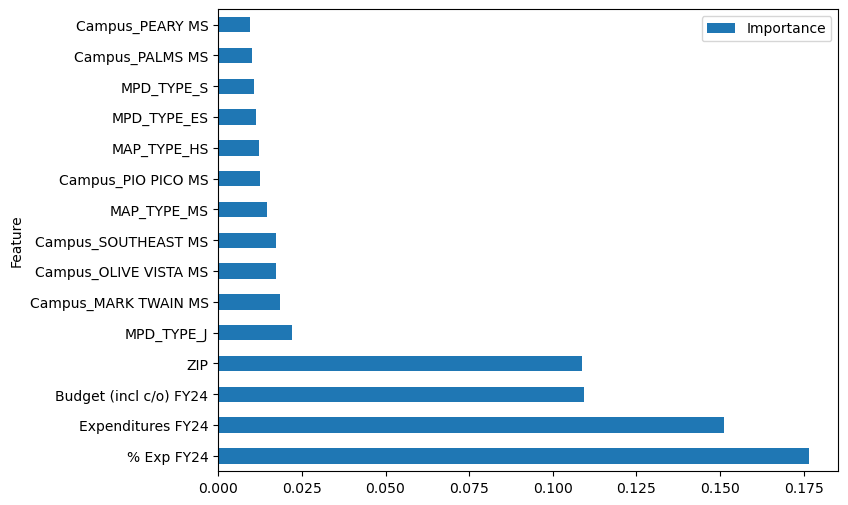

In [19]:
feature_importance_df.head(15).plot(kind='barh', x='Feature', figsize=(8,6))

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, log_loss
)
from scipy.special import softmax

TEST_SIZE = 0.20       # 20% test
VAL_SIZE = 0.25        # 25% of (train+val) used as val
N_ESTIMATORS = 200
RANDOM_STATE = 42

# Composite metric weights: [accuracy, precision, recall, f1]
COMPOSITE_WEIGHTS = np.array([1.0, 1.0, 1.0, 1.0])

# Softmax temperature 
TEMPERATURE = 1.0


# 1. Train / Val / Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_train_val
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# 2. Train standard Random Forest
rf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

# Standard RF predictions (equal-weight voting)
proba_std = rf.predict_proba(X_test)
y_pred_std = np.argmax(proba_std, axis=1)
logloss_std = log_loss(y_test, proba_std)

print("\n=== Standard Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_std))
print("Log-loss:", logloss_std)
print("\nClassification report:\n", classification_report(y_test, y_pred_std))

# 3. Compute per-tree metrics on validation set
tree_metrics = []   # rows: [acc, prec, rec, f1] per tree

for tree in rf.estimators_:
    val_pred = tree.predict(X_val)
    acc = accuracy_score(y_val, val_pred)
    prec = precision_score(y_val, val_pred, zero_division=0)
    rec = recall_score(y_val, val_pred, zero_division=0)
    f1 = f1_score(y_val, val_pred, zero_division=0)
    tree_metrics.append([acc, prec, rec, f1])

tree_metrics = np.array(tree_metrics)  # shape: (n_trees, 4)

# Composite score = weighted sum of [acc, prec, rec, f1]
composite_scores = tree_metrics.dot(COMPOSITE_WEIGHTS)

# Softmax over trees -> normalized weights that sum to 1
weights = softmax(composite_scores / TEMPERATURE)

print("\nFirst 5 composite scores:", np.round(composite_scores[:5], 4))
print("First 5 weights:", np.round(weights[:5], 4))
print("Sum of all weights (should be 1.0):", weights.sum())

# view tree metrics + weights
tree_summary = pd.DataFrame(
    tree_metrics,
    columns=["acc", "prec", "rec", "f1"]
)
tree_summary["composite"] = composite_scores
tree_summary["weight"] = weights
print("\nPer-tree metric summary (head):")
print(tree_summary.head())

# 4. Softmax-weighted ensemble on test set
# Start with zeros, then add each tree's probabilities scaled by its weight
proba_weighted = np.zeros_like(proba_std)

for w, tree in zip(weights, rf.estimators_):
    proba_weighted += w * tree.predict_proba(X_test)

y_pred_weighted = np.argmax(proba_weighted, axis=1)
logloss_weighted = log_loss(y_test, proba_weighted)

print("\n=== Softmax-Weighted Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("Log-loss:", logloss_weighted)
print("\nClassification report:\n", classification_report(y_test, y_pred_weighted))

Train: (51, 107) Val: (17, 107) Test: (18, 107)

=== Standard Random Forest ===
Accuracy: 0.6111111111111112
Log-loss: 0.6067079595723793

Classification report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.60      0.67      0.63         9

    accuracy                           0.61        18
   macro avg       0.61      0.61      0.61        18
weighted avg       0.61      0.61      0.61        18



C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier 


First 5 composite scores: [1.833  3.2178 2.3852 2.21   3.0147]
First 5 weights: [0.0027 0.0108 0.0047 0.0039 0.0088]
Sum of all weights (should be 1.0): 1.0

Per-tree metric summary (head):
        acc      prec    rec        f1  composite    weight
0  0.529412  0.500000  0.375  0.428571   1.832983  0.002700
1  0.823529  1.000000  0.625  0.769231   3.217760  0.010784
2  0.647059  0.666667  0.500  0.571429   2.385154  0.004690
3  0.529412  0.500000  0.625  0.555556   2.209967  0.003936
4  0.764706  0.750000  0.750  0.750000   3.014706  0.008802

=== Softmax-Weighted Random Forest ===
Accuracy: 0.6111111111111112
Log-loss: 0.6327873860093123

Classification report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.60      0.67      0.63         9

    accuracy                           0.61        18
   macro avg       0.61      0.61      0.61        18
weighted avg       0.61      0.61      0.61        18


C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier 

In [21]:
# Rebuilding metrics_matrix, val_proba_per_tree, test_proba_per_tree

metrics_matrix = []            # Will become shape (n_trees, 4)
val_proba_per_tree = []        # list of arrays
test_proba_per_tree = []       # list of arrays

for tree in rf.estimators_:
    # Per-tree predictions on validation set
    val_pred = tree.predict(X_val.values)
    acc = accuracy_score(y_val, val_pred)
    prec = precision_score(y_val, val_pred, zero_division=0)
    rec = recall_score(y_val, val_pred, zero_division=0)
    f1 = f1_score(y_val, val_pred, zero_division=0)
    metrics_matrix.append([acc, prec, rec, f1])

    # Per-tree probabilities on val and test sets
    val_proba_per_tree.append(tree.predict_proba(X_val.values))
    test_proba_per_tree.append(tree.predict_proba(X_test.values))

metrics_matrix = np.array(metrics_matrix)

print("metrics_matrix shape:", metrics_matrix.shape)
print("example row:", metrics_matrix[0])

metrics_matrix shape: (200, 4)
example row: [0.52941176 0.5        0.375      0.42857143]


In [22]:
# REQUIRED SETUP BEFORE WEIGHT TUNING

temperature = 1.0   # Default softmax temperature is 1 for reference

metrics_matrix = []
val_proba_per_tree = []
test_proba_per_tree = []

for tree in rf.estimators_:
    # Per tree validation predictions
    val_pred = tree.predict(X_val.values)
    acc = accuracy_score(y_val, val_pred)
    prec = precision_score(y_val, val_pred, zero_division=0)
    rec = recall_score(y_val, val_pred, zero_division=0)
    f1 = f1_score(y_val, val_pred, zero_division=0)
    metrics_matrix.append([acc, prec, rec, f1])

    # Per tree probabilities on val/test
    val_proba_per_tree.append(tree.predict_proba(X_val.values))
    test_proba_per_tree.append(tree.predict_proba(X_test.values))

metrics_matrix = np.array(metrics_matrix)

print("metrics_matrix shape:", metrics_matrix.shape)
print("first row of metrics_matrix:", metrics_matrix[0])
print("temperature set to:", temperature)

metrics_matrix shape: (200, 4)
first row of metrics_matrix: [0.52941176 0.5        0.375      0.42857143]
temperature set to: 1.0


In [23]:
import itertools
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, classification_report
from scipy.special import softmax

# Pre compute per tree probabilities on val and test sets
val_proba_per_tree = [tree.predict_proba(X_val.values) for tree in rf.estimators_]
test_proba_per_tree = [tree.predict_proba(X_test.values) for tree in rf.estimators_]

def evaluate_weight_vector(weight_vec, metrics_matrix,
                           val_proba_per_tree, y_val, temperature=1.0):
    """
    Given a 4-dim weight vector [w_acc, w_prec, w_rec, w_f1],
    compute composite scores -> softmax tree weights -> validation performance.
    Returns (val_logloss, val_accuracy, tree_weights).
    """
    weight_vec = np.array(weight_vec, dtype=float)
    # Per tree composite score
    composite_scores = metrics_matrix @ weight_vec
    # Softmax to get non-negative weights that sum to 1
    tree_weights = softmax(composite_scores / temperature)

    # Aggregate weighted probabilities on validation set
    proba_val = np.zeros_like(val_proba_per_tree[0])
    for tw, p in zip(tree_weights, val_proba_per_tree):
        proba_val += tw * p

    val_logloss = log_loss(y_val, proba_val)
    val_acc = accuracy_score(y_val, np.argmax(proba_val, axis=1))
    return val_logloss, val_acc, tree_weights

# Define a small grid of candidate weights
candidate_vals = [0.0, 0.5, 1.0, 2.0]  # you can tweak/expand this later
weight_grid = list(itertools.product(candidate_vals, repeat=4))
print(f"Evaluating {len(weight_grid)} weight combinations...")

best = {
    "w": None,
    "val_logloss": np.inf,
    "val_acc": 0.0
}

for w in weight_grid:
    ll, acc, _ = evaluate_weight_vector(
        w, metrics_matrix, val_proba_per_tree, y_val, temperature=temperature
    )
    if ll < best["val_logloss"]:
        best["w"] = w
        best["val_logloss"] = ll
        best["val_acc"] = acc

print("\nBest weight vector [acc, prec, rec, f1]:", best["w"])
print(f"Best validation log-loss: {best['val_logloss']:.4f}")
print(f"Best validation accuracy: {best['val_acc']:.4f}")

# Use best weights to evaluate on TEST set
best_w = np.array(best["w"], dtype=float)
best_composite_scores = metrics_matrix @ best_w
best_tree_weights = softmax(best_composite_scores / temperature)

# Aggregate weighted probabilities on test set
proba_test = np.zeros_like(test_proba_per_tree[0])
for tw, p in zip(best_tree_weights, test_proba_per_tree):
    proba_test += tw * p

test_logloss = log_loss(y_test, proba_test)
y_pred_test = np.argmax(proba_test, axis=1)

print("\n=== Softmax RF with TUNED weights (Test set) ===")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test log-loss: {test_logloss:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_test))

Evaluating 256 weight combinations...

Best weight vector [acc, prec, rec, f1]: (2.0, 2.0, 2.0, 2.0)
Best validation log-loss: 0.3971
Best validation accuracy: 0.8824

=== Softmax RF with TUNED weights (Test set) ===
Test accuracy: 0.5556
Test log-loss: 0.6647

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56         9
           1       0.56      0.56      0.56         9

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.56        18
weighted avg       0.56      0.56      0.56        18



In [24]:
# Export the cleaned dataset with funding performance metadata
final_clean.to_csv("school_funding_performance_clean.csv", index=False)
print("Exported as school_funding_performance_clean.csv")

Exported as school_funding_performance_clean.csv


In [25]:
# Define the usable columns (assumed best fit by looking)
usable_columns = [
    "CDSCODE",
    "MPD_NAME",
    "ZIP",
    "MPD_TYPE",
    "MAP_TYPE",
    "CHARTER",
    "LD",
    "Campus",
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24",
    "Pct_Met_Above",
    "Mean_Score"
]

if "Performance_Level" in final_clean.columns:
    usable_columns.append("Performance_Level")

usable_df = final_clean[usable_columns]

# Export to CSV
usable_df.to_csv("school_usable_columns.csv", index=False)
print("Exported: school_usable_columns.csv")

usable_df.head()

Exported: school_usable_columns.csv


,CDSCODE,MPD_NAME,ZIP,MPD_TYPE,MAP_TYPE,CHARTER,LD,Campus,Budget (incl c/o) FY24,Expenditures FY24,% Exp FY24,Pct_Met_Above,Mean_Score
0,19647336057939,NIMITZ MS,90255,J,MS,,0,NIMITZ MS,18802827.0,16689938.43,0.887629,34.657500,2499.500000
1,19647336061394,AUDUBON MS,90008,J,MS,,0,AUDUBON MS,12618220.0,10690015.33,0.847189,27.157500,2473.133333
2,19647331931054,WESTSIDE GLBL AWR MAG,90292,SP,M,,0,WESTSIDE GLBL AWR MAG,5263785.0,4628859.74,0.879379,45.118571,2482.016667
3,19647336107064,PIO PICO MS,90019,J,MS,,0,PIO PICO MS,6573638.0,4915339.49,0.747735,36.482500,2503.633333
4,19647336057889,BELVEDERE MS,90063,J,MS,,0,BELVEDERE MS,13920639.0,11795271.36,0.847323,30.900000,2491.900000


# Linear SVM

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Recreate the same train/test split for fairness
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale X
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_svm)
X_test_svm_scaled = scaler_svm.transform(X_test_svm)

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, log_loss

# probability = True enables predict_proba
svm_linear = SVC(kernel="linear", probability=True, random_state=42)

svm_linear.fit(X_train_svm_scaled, y_train_svm)

SVC(kernel='linear', probability=True, random_state=42)

In [29]:
# Predict class labels
y_pred_svm = svm_linear.predict(X_test_svm_scaled)

# Predict probabilities for log loss
proba_svm = svm_linear.predict_proba(X_test_svm_scaled)

print("Linear SVM Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print("Linear SVM Log-loss:", log_loss(y_test_svm, proba_svm))

print("\nClassification Report:")
print(classification_report(y_test_svm, y_pred_svm))

Linear SVM Accuracy: 0.5909090909090909
Linear SVM Log-loss: 0.7150278022862803

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.55      1.00      0.71        11

    accuracy                           0.59        22
   macro avg       0.78      0.59      0.51        22
weighted avg       0.78      0.59      0.51        22



In [30]:
import pandas as pd
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": svm_linear.coef_[0]
}).sort_values("Coefficient", ascending=False)

coef_df.head(15)

,Feature,Coefficient
2,% Exp FY24,0.328171
56,Campus_KNOLLWOOD PREP ACAD,0.173528
85,Campus_ROYBAL LC,0.134023
96,Campus_TORRES RENAISSANCE,0.120487
28,Campus_BRADLEY GLBL AWR MAG,0.092264
79,Campus_PIO PICO MS,0.087914
18,MAP_TYPE_MS,0.080211
81,Campus_REED MS,0.079131
71,Campus_MULHOLLAND MS,0.077844
29,Campus_BURROUGHS MS,0.075301


trying non linear svm because reults are asymetric

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Same scaled data as linear SVM
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)

svm_rbf.fit(X_train_svm_scaled, y_train_svm)

# Predictions
y_pred_rbf = svm_rbf.predict(X_test_svm_scaled)
proba_rbf = svm_rbf.predict_proba(X_test_svm_scaled)

print("RBF SVM Accuracy:", accuracy_score(y_test_svm, y_pred_rbf))
print("RBF SVM Log-loss:", log_loss(y_test_svm, proba_rbf))
print("\nClassification Report:\n", classification_report(y_test_svm, y_pred_rbf))

RBF SVM Accuracy: 0.7272727272727273
RBF SVM Log-loss: 0.7933964480537927

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.67      0.91      0.77        11

    accuracy                           0.73        22
   macro avg       0.76      0.73      0.72        22
weighted avg       0.76      0.73      0.72        22



much better

Testing Naive Bayes (Gaussian) next

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, log_loss

nb = GaussianNB()
nb.fit(X_train_svm_scaled, y_train_svm)

y_pred_nb = nb.predict(X_test_svm_scaled)
proba_nb = nb.predict_proba(X_test_svm_scaled)

print("Naive Bayes Accuracy:", accuracy_score(y_test_svm, y_pred_nb))
print("Naive Bayes Log-loss:", log_loss(y_test_svm, proba_nb))
print("\nClassification Report:\n", classification_report(y_test_svm, y_pred_nb))

Naive Bayes Accuracy: 0.5
Naive Bayes Log-loss: 5.670793403278697

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.50      1.00      0.67        11

    accuracy                           0.50        22
   macro avg       0.25      0.50      0.33        22
weighted avg       0.25      0.50      0.33        22



C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\codyl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

not worth trying to fix

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Trying k = 3 neighbors because of smaller dataset
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_svm_scaled, y_train_svm)

y_pred_knn = knn.predict(X_test_svm_scaled)
proba_knn = knn.predict_proba(X_test_svm_scaled)

print("kNN Accuracy:", accuracy_score(y_test_svm, y_pred_knn))
print("kNN Log-loss:", log_loss(y_test_svm, proba_knn))
print("\nClassification Report:\n", classification_report(y_test_svm, y_pred_knn))

# note from after running... wow that logloss is high lol

kNN Accuracy: 0.6818181818181818
kNN Log-loss: 3.72911292776203

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.64      0.82      0.72        11

    accuracy                           0.68        22
   macro avg       0.70      0.68      0.68        22
weighted avg       0.70      0.68      0.68        22



C:\Users\codyl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\codyl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\codyl\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\codyl\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\codyl\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Gradient Boosting time

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Gradient Boosting works fine on scaled or unscaled data
# reuse the same scaled features you used for SVM
# X_train_svm_scaled, X_test_svm_scaled, y_train_svm, y_test_svm

gb = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,   
    learning_rate=0.1,  
    max_depth=3         
)

gb.fit(X_train_svm_scaled, y_train_svm)

y_pred_gb = gb.predict(X_test_svm_scaled)
proba_gb = gb.predict_proba(X_test_svm_scaled)

print("Gradient Boosting Accuracy:", accuracy_score(y_test_svm, y_pred_gb))
print("Gradient Boosting Log-loss:", log_loss(y_test_svm, proba_gb))

print("\nClassification Report:\n", classification_report(y_test_svm, y_pred_gb))

Gradient Boosting Accuracy: 0.6818181818181818
Gradient Boosting Log-loss: 0.7236162451469907

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.67      0.73      0.70        11

    accuracy                           0.68        22
   macro avg       0.68      0.68      0.68        22
weighted avg       0.68      0.68      0.68        22



one last check just to see if restrictions can help

In [41]:
X_reduced = final_clean[[
    "ZIP",
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24"
]].copy()

y_reduced = y.copy()  

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y_reduced, test_size=0.25, random_state=42, stratify=y_reduced
)

scaler_red = StandardScaler()
X_train_red_s = scaler_red.fit_transform(X_train_red)
X_test_red_s = scaler_red.transform(X_test_red)

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, log_loss

svm_rbf_red = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
svm_rbf_red.fit(X_train_red_s, y_train_red)

y_pred_rbf_red = svm_rbf_red.predict(X_test_red_s)
proba_rbf_red = svm_rbf_red.predict_proba(X_test_red_s)

print("RBF SVM (Reduced Features) Accuracy:", accuracy_score(y_test_red, y_pred_rbf_red))
print("RBF SVM (Reduced) Log-loss:", log_loss(y_test_red, proba_rbf_red))
print("\nClassification Report:\n", classification_report(y_test_red, y_pred_rbf_red))

RBF SVM (Reduced Features) Accuracy: 0.6363636363636364
RBF SVM (Reduced) Log-loss: 0.6127530940852953

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.67      0.55      0.60        11

    accuracy                           0.64        22
   macro avg       0.64      0.64      0.63        22
weighted avg       0.64      0.64      0.63        22



In [44]:
import numpy as np
import pandas as pd
from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, log_loss,
    precision_score, recall_score, f1_score
)
from scipy.special import softmax

# Set up data 
# Use your cleaned modeling dataset
model_df = final_clean.copy()

# Restricted feature set based on importance graph
feature_cols = [
    "ZIP",
    "Budget (incl c/o) FY24",
    "Expenditures FY24",
    "% Exp FY24"
]

# Target variable 
threshold = model_df["Pct_Met_Above"].median()
y = (model_df["Pct_Met_Above"] >= threshold).astype(int).values

# Select features
X = model_df[feature_cols].copy()

# Ensure all are numeric
for col in feature_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")

# Drop rows with any missing values
valid_mask = X.notna().all(axis=1)
X = X[valid_mask]
y = y[valid_mask.values]

# Convert X to NumPy array
X = X.values

print("Final restricted dataset shape:", X.shape, y.shape)

# 2. Train/Val/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Train a standard Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=None
)

rf.fit(X_train, y_train)

# Standard RF predictions
proba_std = rf.predict_proba(X_test)
y_pred_std = np.argmax(proba_std, axis=1)
log_std = log_loss(y_test, proba_std)

print("\n=== Standard Random Forest (Restricted Features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_std))
print("Log-loss:", log_std)
print("\nClassification Report:\n", classification_report(y_test, y_pred_std))


# Compute per-tree validation metrics
tree_metrics = []
val_proba_per_tree = []
test_proba_per_tree = []

for tree in rf.estimators_:
    preds_val = tree.predict(X_val)

    acc = accuracy_score(y_val, preds_val)
    prec = precision_score(y_val, preds_val, average='weighted', zero_division=0)
    rec = recall_score(y_val, preds_val, average='weighted', zero_division=0)
    f1 = f1_score(y_val, preds_val, average='weighted', zero_division=0)

    tree_metrics.append([acc, prec, rec, f1])

    val_proba_per_tree.append(tree.predict_proba(X_val))
    test_proba_per_tree.append(tree.predict_proba(X_test))

metrics_matrix = np.array(tree_metrics)
val_proba_per_tree = np.array(val_proba_per_tree)
test_proba_per_tree = np.array(test_proba_per_tree)

print("\nPer-tree metrics matrix shape:", metrics_matrix.shape)

# Helper function: evaluate weight vector on validation set
def evaluate_weight_vector(w, metrics_matrix, val_proba_per_tree, y_val, temperature=1.0):
    w = np.array(w, dtype=float)
    composite_scores = metrics_matrix.dot(w)
    tree_weights = softmax(composite_scores / temperature)

    # Weighted probabilities for validation set
    val_proba_weighted = np.tensordot(tree_weights, val_proba_per_tree, axes=(0, 0))
    
    val_ll = log_loss(y_val, val_proba_weighted)
    val_pred = np.argmax(val_proba_weighted, axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    
    return val_ll, val_acc, tree_weights

# Grid search over weight combinations
temperature = 1.0
candidate_vals = [0.0, 1.0, 2.0, 3.0]
weight_grid = list(product(candidate_vals, repeat=4))  # 4^4 = 256 combos

best = {
    "w": None,
    "val_logloss": np.inf,
    "val_acc": 0.0,
    "weights_per_tree": None
}

print(f"\nEvaluating {len(weight_grid)} weight combinations...")

for w in weight_grid:
    ll, acc, tw = evaluate_weight_vector(
        w, metrics_matrix, val_proba_per_tree, y_val, temperature
    )

    if ll < best["val_logloss"]:
        best["w"] = w
        best["val_logloss"] = ll
        best["val_acc"] = acc
        best["weights_per_tree"] = tw

print("\nBest weight vector [acc, prec, rec, f1]:", best["w"])
print("Best validation log-loss:", round(best["val_logloss"], 4))
print("Best validation accuracy:", round(best["val_acc"], 4))

# Evaluate tuned Softmax RF on the TEST set
best_tree_weights = best["weights_per_tree"]

# Weighted probabilities for test set
test_proba_weighted = np.tensordot(best_tree_weights, test_proba_per_tree, axes=(0, 0))
test_logloss = log_loss(y_test, test_proba_weighted)
y_test_pred = np.argmax(test_proba_weighted, axis=1)

print("\n=== Softmax RF with TUNED weights (Restricted Features, Test set) ===")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Log-loss:", test_logloss)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Final restricted dataset shape: (86, 4) (86,)
Train: (54, 4), Val: (14, 4), Test: (18, 4)

=== Standard Random Forest (Restricted Features) ===
Accuracy: 0.6111111111111112
Log-loss: 0.6530559742267938

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.60      0.67      0.63         9

    accuracy                           0.61        18
   macro avg       0.61      0.61      0.61        18
weighted avg       0.61      0.61      0.61        18


Per-tree metrics matrix shape: (100, 4)

Evaluating 256 weight combinations...

Best weight vector [acc, prec, rec, f1]: (3.0, 3.0, 3.0, 3.0)
Best validation log-loss: 0.3327
Best validation accuracy: 0.8571

=== Softmax RF with TUNED weights (Restricted Features, Test set) ===
Test Accuracy: 0.5555555555555556
Test Log-loss: 0.8240223372995491

Classification Report:
               precision    recall  f1-score   support

           0      